In [1]:
# Libraries needed

import random
import numpy as np
import math
from collections import defaultdict
import time
import sklearn
from sklearn import linear_model
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    func = sigmoid
    return func(x) * (1 - func(x))

In [2]:
# Each underlying system is represented in the form of SDFA

class SDFA:
    def __init__(self, transition_dict):
        self.stateSpace = transition_dict.keys()
        self.transitions = transition_dict
        self.startState = '__INITIAL__'
        self.closeState = '__FINAL__'
    
    # Output a random trace 
    def random_sample(self):
        trace = []
        currState = self.startState
        trace.append(currState)
        while not currState == self.closeState:
            connectedStates = self.transitions[currState]
            samples, weights = [], []
            for sample in connectedStates.keys():
                samples.append(sample)
                weights.append(connectedStates[sample])
            currState = (random.choices(samples, weights=weights, k=1))[0]
            trace.append(currState)
        return trace
    
    # generate log of any size we want
    def generateLog(self, size):
        i = 0
        log = []
        while i < size:
            log.append(self.random_sample())
            i = i + 1
        return log
    
    # find the probability of a particular trace
    def find_probability(self, trace):
        prob = 1.0
        L = len(trace)
        i = 0
        currState = trace[i]
        while not currState == self.closeState:
            nextState = trace[i+1]
            if not nextState in self.transitions[currState].keys():
                return 0
            cond_prob = self.transitions[currState][nextState] / sum(self.transitions[currState].values())
            prob = prob * cond_prob
            currState = nextState
            i += 1
        return prob
    
    # given a log, this function finds the accumulative probability of all traces in the log
    def accumulative_prob(self, log):
        prob = 0.0
        for trace in log:
            prob += self.find_probability(trace)
        return prob
    
    # This function is used to generate the test subset S', using breadth first search
    def generate_eval_bfs(self, threshold):
        count = 0
        accuLog = []
        queue = []
        startstate = "__INITIAL__"
        assert startstate in self.transitions.keys()
        path = []
        queue.append((startstate, path))
        while self.accumulative_prob(accuLog) < threshold and len(queue) > 0:
            state, path = queue.pop(0)
            if state == "__FINAL__":
                path = path + [state]
                accuLog.append(path)
                count += 1
            else:
                nextStates = {k: v for k, v in sorted((self.transitions[state]).items(), key=lambda item: item[1])}
                path = path + [state]
                for nextState in nextStates:
                    queue.append((nextState, path))
        unique_set = set()
        for L in accuLog:
            unique_set.add("/".join(L))
        print("test size = ", len(unique_set)) # telling us how many traces S' contain
        return unique_set

In [5]:
# Before a trace is fed into a regression model, it must be encoded to a numeric vector first.
# The embedder we use in this project is Byte-pair Encoding.

class Embedding:
    def __init__(self, log):
        self.Log = log
        self.vocab_size = 1
        self.mask_dict = {"__INITIAL__":1, "PADDING": -1}
        self.maxLength = max([len(l[:-1]) for l in log])
        self.calculate_vocab()
    
    def calculate_vocab(self):
        for trace_with_start_and_end_tag in self.Log:
            trace = trace_with_start_and_end_tag[1:-1]
            word_vector = [self.mask_dict["__INITIAL__"]]
            trace_length = min(len(trace), self.maxLength - 1)
            for event in trace[:trace_length]:
                if not event in self.mask_dict.keys():
                    self.vocab_size += 1
                    self.mask_dict[event] = self.vocab_size
    
    def embed_new_trace(self, T):
        trace = T[1:-1]
        word_vector = [self.mask_dict["__INITIAL__"]]
        trace_length = min(len(trace), self.maxLength - 1)
        for event in trace[:trace_length]:
            if event in self.mask_dict.keys():
                word_vector.append(self.mask_dict[event])
            else:
                word_vector.append(self.mask_dict["PADDING"])
        return word_vector
    
    def embed_with_padding(self, T):
        trace = T[1:-1]
        word_vector = [self.mask_dict["__INITIAL__"]]
        trace_length = min(len(trace), self.maxLength - 1)
        for event in trace[:trace_length]:
            if event in self.mask_dict.keys():
                word_vector.append(self.mask_dict[event])
            else:
                word_vector.append(self.mask_dict["PADDING"])
        if len(trace) < self.maxLength-1:
            paddings = [self.mask_dict["PADDING"]] * (self.maxLength-1-len(trace))
            word_vector += paddings
        return word_vector

In [6]:
""" First model self attention """


class Self_Attention_FN:
    def __init__(self, event_logs):
        # add 1 for biased item
        self.log = event_logs
        self.maxLength = max([len(l[:-1]) for l in event_logs])
        self.dimension = 2
        
        # Initialized matrices(query and key) and the weight vector
        # These things are updated during backpropagation:
        self.RP = self.nn_matrix()
        self.RT = self.nn_matrix()
        self.KT = self.nn_matrix()
        self.KP = self.nn_matrix()
        
        self.G = [0.2] * self.maxLength
        self.Ww = self.nn_matrix()
        self.Wm = self.nn_matrix()
        
        self.activation = sigmoid
        self.derivative = sigmoid_derivative
        self.learning_rate = 1e-1
        self.threshold = 1e-2
        #self.Weights = []
        self.embedding = Embedding(self.log)
        self.embedding.calculate_vocab()
        self.positionEncoding = list(range(self.maxLength))
        self.epochs = 1000

    def nn_matrix(self):
        M = []
        for i in range(self.maxLength):
            M.append([0.5] * self.maxLength)
        return np.array(M)
    
    def setEpoch(self, n):
        self.epochs = n
    
    def setLearningRate(self, n):
        self.learning_rate = n
        
    def predict(self, trace):
        vector = self.embedding.embed_with_padding(trace)
        PE = self.positionEncoding
        W = self.Ww
        M = self.Wm
        F = []
        assert len(vector) == len(PE)
        for i in range(len(vector)):
            T = []
            P = []
            for j in range(len(vector)):
                T.append(W[i][j] * vector[i] * self.RT[i][j] * vector[j] * self.KT[j][i])
                P.append(M[i][j] * PE[i] * self.RP[i][j] * PE[j] * self.KP[j][i])
            x2 = sum(P) + sum(T)
            fi = self.activation(x2)
            F.append(self.G[i] * fi)
        return self.activation(sum(F))
    
    
    def train(self, Log, Y):
        for epoch in range(self.epochs):
            for i in range(len(Log)):
                trace = Log[i]
                PE = self.positionEncoding
                vector = self.embedding.embed_with_padding(trace)
                assert len(vector) == len(PE)
                
                #training:
                y = Y[i]
                y_hat = self.predict(trace)
                W = self.Ww
                M = self.Wm
                F = []
                Fi = []
                X1 = []
                p_relevance = self.nn_matrix()
                t_relevance = self.nn_matrix()
                
                for l1 in range(len(vector)):
                    T = []
                    P = []
                    for l2 in range(len(vector)):
                        T.append(W[l1][l2] * vector[l1] * self.RT[l1][l2] * vector[l2] * self.KT[l2][l1])
                        P.append(M[l1][l2] * PE[l1] * self.RP[l1][l2] * PE[l2] * self.KP[l2][l1])
                        t_relevance[l1][l2] = W[l1][l2] * vector[l1] * self.RT[l1][l2] * vector[l2] * self.KT[l2][l1]
                        p_relevance[l1][l2] = M[l1][l2] * PE[l1] * self.RP[l1][l2] * PE[l2] * self.KP[l2][l1]
                    x2 = sum(P) + sum(T)
                    fi = self.activation(x2)
                    X1.append(x2)
                    F.append(self.G[l1] * fi)
                    Fi.append(fi)
                
                x = self.activation(sum(F))
                
                
                #updating parameters using back propagation:
                deltaWW = self.nn_matrix()
                deltaWM = self.nn_matrix()
                deltaQT = self.nn_matrix()
                deltaQP = self.nn_matrix()
                deltaKT = self.nn_matrix()
                deltaKP = self.nn_matrix()
                for l1 in range(len(vector)):
                    for l2 in range(len(vector)):
                        deltaWW[l1][l2] = self.learning_rate*(y_hat-y)*self.derivative(x)*self.G[l1]*self.derivative(X1[l1])*t_relevance[l1][l2]
                        deltaWM[l1][l2] = self.learning_rate*(y_hat-y)*self.derivative(x)*self.G[l1]*self.derivative(X1[l1])*p_relevance[l1][l2]
                        deltaQT[l1][l2] = self.learning_rate*(y_hat-y)*self.derivative(x)*self.G[l1]*self.derivative(X1[l1])*self.Ww[l1][l2]*vector[l1]*self.KT[l2][l1]*vector[l2]
                        deltaQP[l1][l2] = self.learning_rate*(y_hat-y)*self.derivative(x)*self.G[l1]*self.derivative(X1[l1])*self.Wm[l1][l2]*PE[l1]*self.KP[l2][l1]*PE[l2]
                        deltaKT[l2][l1] = self.learning_rate*(y_hat-y)*self.derivative(x)*self.G[l1]*self.derivative(X1[l1])*self.Ww[l1][l2]*vector[l1]*self.RT[l1][l2]*vector[l2]
                        deltaKP[l2][l1] = self.learning_rate*(y_hat-y)*self.derivative(x)*self.G[l1]*self.derivative(X1[l1])*self.Wm[l1][l2]*PE[l1]*self.RP[l1][l2]*PE[l2]
                              
                for g in range(len(self.G)):
                    self.G[g] = self.G[g] - self.learning_rate * (y_hat-y)*self.derivative(x) * Fi[g]
                    
                for l1 in range(len(vector)):
                    for l2 in range(len(vector)):
                        self.Ww[l1][l2] = self.Ww[l1][l2] - deltaWW[l1][l2]
                        self.Wm[l1][l2] = self.Wm[l1][l2] - deltaWM[l1][l2]
                        self.RP[l1][l2] = self.RP[l1][l2] - deltaQP[l1][l2]
                        self.RT[l1][l2] = self.RT[l1][l2] - deltaQT[l1][l2]
                        self.KP[l1][l2] = self.KP[l1][l2] - deltaKP[l1][l2]
                        self.KT[l1][l2] = self.KT[l1][l2] - deltaKT[l1][l2]

      

In [7]:
"""Second model Logistic Regression """

class LR_model:
    def __init__(self, event_log):
        self.log = event_log
        self.maxLength = max([len(l[:-1]) for l in event_log])
        self.weights = [0.1] * self.maxLength                 # initialized weights
        self.embedding = Embedding(self.log)
        self.embedding.calculate_vocab()
        self.epoch = 300
        self.learning_rate = 0.1
        self.threshold = 1e-3
    
    # we calculate the linear product of the input vector and the weight vector
    # Afterwards, we feed the linear product result into an activation function, get the final output
    def predict(self, trace):
        x = 0.0
        vector = self.embedding.embed_with_padding(trace)
        for i in range(self.maxLength):
            x += self.weights[i] * vector[i]
        z = sigmoid(x)
        return z
    
    def train(self, Y):
        epoch = 0
        while epoch < self.epoch:
            i = 0
            for t in self.log:
                vector = self.embedding.embed_with_padding(t)
                y = Y[i]
                y_ = self.predict(t)
                x = self.weighted_sum(vector)
                if not abs(y-y_) <= self.threshold:
                    for l in range(self.maxLength):
                        self.weights[l] = self.weights[l] - self.learning_rate * (y_- y) * sigmoid_derivative(x) * vector[l]
                i += 1
            epoch += 1
    
    # Change the training iteration of the model
    def setEpoch(self, n):
        self.epoch = n
    
    # Change the learning rate of the model
    def setLearningRate(self, n):
        self.learning_rate = n
    
    # This function calculates the linear product of the input vector and weight vector
    # This function is called during back propagation
    def weighted_sum(self, vector):
        x = 0.0
        for i in range(len(vector)):
            x += vector[i] * self.weights[i]
        return x

In [6]:
"""third model Neural Network """

class NN_model:
    def __init__(self, event_log):
        self.log = event_log
        self.maxLength = max([len(l[:-1]) for l in event_log])
        self.embedding = Embedding(self.log)
        self.embedding.calculate_vocab()
        self.epoch = 300
        self.model = None
    
    def setEpoch(self, n):
        self.epoch = n
    
    def buildModel(self):
        # For simplicity, I use the MLPRegressor model provided by the sklearn library.
        self.model = MLPRegressor(random_state=1, max_iter=self.epoch)
    
    def train(self, Y):
        assert not self.model == None
        embeddings = []
        for t in self.log:
            embeddings.append(self.embedding.embed_with_padding(t))
        self.model.fit(embeddings, Y)
    
    def predict(self, trace):
        vector = self.embedding.embed_with_padding(trace)
        return self.model.predict([vector])[0]

In [7]:
# For each uniqur trace, we find its probability with respect to the log
def log_frequencies(log):
    trace_freq_dict = defaultdict(int)
    size = len(log)
    for trace in log:
        processed_trace = "/".join(trace)
        trace_freq_dict[processed_trace] += 1
    for t in trace_freq_dict.keys():
        trace_freq_dict[t] = trace_freq_dict[t] / size
    return trace_freq_dict

# Given a model and a system, calculate the mae of the model with respect to the system.
def mean_absolute_error(EVAL, model, system):
    N = len(EVAL)
    total_probs = 0.0
    for T in EVAL:
        trace = T.split("/")
        embedding = model.embedding.embed_new_trace(trace)
        pm = min(model.predict(embedding), 1)
        ps = system.find_probability(trace)
        total_probs += abs(pm-ps)
    return total_probs / N

# Similar to above, find mse
def mean_square_error(EVAL, model, system):
    N = len(EVAL)
    total_probs = 0.0
    for T in EVAL:
        trace = T.split("/")
        embedding = model.embedding.embed_new_trace(trace)
        pm = min(model.predict(embedding), 1)
        ps = system.find_probability(trace)
        total_probs += (pm-ps) ** 2
    return total_probs / N

In [8]:
""" Since the models we use are recorded in json file, we need this function to extract these models from json files """

def json_to_transition_functions(filepath):
    System_state_list = dict()
    label_ids = dict()
    file = open(filepath, "r")
    json_dict = json.load(file)
    file.close()
    Nodes = json_dict["nodes"]
    transitions = json_dict["arcs"]
    for node in Nodes:
        id = node['id']
        label = node['label']
        label_ids[id] = label
    # initialise transitions dictionary  
    for i in label_ids.values():
        System_state_list[i] = dict()
    for arc in transitions:
        source = label_ids[arc['from']]
        to = label_ids[arc['to']]
        freq = arc['freq']
        System_state_list[source][to] = freq
    return System_state_list

In [9]:
filename = "system_10/CoSeLog_WABO_1_0.040.json" # To use a new model, change this variable to another file


system_transitions = json_to_transition_functions(filename)
sdfa = SDFA(system_transitions)

In [10]:
# generate S'

# some models are sparse and generates traces very slowly. If you set this parameter too high, you may end very late, be careful!
EVAL = sdfa.generate_eval_bfs(0.835)
uniqueL = []
for t in EVAL:
    uniqueL.append(t.split("/"))
print(sdfa.accumulative_prob(uniqueL))

test size =  4281
0.8350195420078954


In [29]:
print("testing log: ", filename)
log_sizes = [10, 100, 1000, 10000, 100000]
for L in log_sizes:
    print(" ****** size of the log = ", L)
    Log = sdfa.generateLog(L)
    logFreq = log_frequencies(Log)
    Log_no_repeat = [unique.split("/") for unique in logFreq.keys()]
    Y = list(logFreq.values())
    print("building self attention model...")
    SAmodel = Self_Attention_FN(Log_no_repeat)
    SAmodel.setEpoch(10)
    start = time.time()
    SAmodel.train(Log_no_repeat, Y)
    print("done")
    print("time spend: ", time.time() - start)
    mae = mean_absolute_error(EVAL, SAmodel, sdfa)
    mse = mean_square_error(EVAL, SAmodel, sdfa)
    print("mean abs error: ", mae)
    print("mean square error: ", mse)
    print("")
    
    print("building Logistic Regression model")
    LRmodel = LR_model(Log_no_repeat)
    LRmodel.setEpoch(300)
    start = time.time()
    LRmodel.train(Y)
    print("time spend: ", time.time() - start)
    print("done")
    mae_lr = mean_absolute_error(EVAL, LRmodel, sdfa)
    mse_lr = mean_square_error(EVAL, LRmodel, sdfa)
    print("mean abs error: ", mae_lr)
    print("mean square error: ", mse_lr)
    print("")
    
    print("building Neural Network... ")
    NNmodel = NN_model(Log_no_repeat)
    NNmodel.buildModel()
    NNmodel.setEpoch(100)
    start = time.time()
    NNmodel.train(Y)
    print("time spend: ", time.time() - start)
    mae_nn = mean_absolute_error(EVAL, NNmodel, sdfa)
    mse_nn = mean_square_error(EVAL, NNmodel, sdfa)
    print("done")
    print("mean abs error: ", mae_nn)
    print("mean square error: ", mse_nn)
    print("")

testing log:  BPIC_2017_300.json
 ****** size of the log =  10
building self attention model...
done
time spend:  0.8239567279815674
mean abs error:  0.11846621556746288
mean square error:  0.01611232206574787

building Logistic Regression model
time spend:  0.15057086944580078
done
mean abs error:  0.7016732846134142
mean square error:  0.4959196235761317

building Neural Network... 
time spend:  0.014929771423339844
done
mean abs error:  0.06097570529925009
mean square error:  0.004723273647882515

 ****** size of the log =  100
building self attention model...
done
time spend:  1.8747692108154297
mean abs error:  0.051890020024538935
mean square error:  0.003753429439482803

building Logistic Regression model
time spend:  0.303206205368042
done
mean abs error:  0.5300835699316534
mean square error:  0.28456281634744046

building Neural Network... 
time spend:  0.04786801338195801
done
mean abs error:  0.671282869411714
mean square error:  0.4541949160015786

 ****** size of the log 

In [41]:
print("testing log: ", filename)
log_sizes = [10, 100, 1000, 10000, 100000]
for L in log_sizes:
    print(" ****** size of the log = ", L)
    Log = sdfa.generateLog(L)
    logFreq = log_frequencies(Log)
    Log_no_repeat = [unique.split("/") for unique in logFreq.keys()]
    Y = list(logFreq.values())
    
    print("building Logistic Regression model")
    LRmodel = LR_model(Log_no_repeat)
    LRmodel.setEpoch(300)
    start = time.time()
    LRmodel.train(Y)
    print("time spend: ", time.time() - start)
    print("done")
    mae_lr = mean_absolute_error(EVAL, LRmodel, sdfa)
    mse_lr = mean_square_error(EVAL, LRmodel, sdfa)
    print("mean abs error: ", mae_lr)
    print("mean square error: ", mse_lr)
    print("")
    
    print("building Neural Network... ")
    NNmodel = NN_model(Log_no_repeat)
    NNmodel.buildModel()
    NNmodel.setEpoch(100)
    start = time.time()
    NNmodel.train(Y)
    print("time spend: ", time.time() - start)
    mae_nn = mean_absolute_error(EVAL, NNmodel, sdfa)
    mse_nn = mean_square_error(EVAL, NNmodel, sdfa)
    print("done")
    print("mean abs error: ", mae_nn)
    print("mean square error: ", mse_nn)
    print("")

testing log:  BPI_Challenge_2018_Control_summary_1.000.json
 ****** size of the log =  10
building Logistic Regression model
time spend:  0.061833858489990234
done
mean abs error:  0.6165739461361706
mean square error:  0.38070302850728593

building Neural Network... 
time spend:  0.013962984085083008
done
mean abs error:  0.300929519899277
mean square error:  0.09062005403979695

 ****** size of the log =  100
building Logistic Regression model
time spend:  0.2603034973144531
done
mean abs error:  0.7154481775119326
mean square error:  0.5128788144399045

building Neural Network... 
time spend:  0.021941661834716797
done
mean abs error:  0.9186362468750259
mean square error:  0.8449539379600739

 ****** size of the log =  1000
building Logistic Regression model
time spend:  0.4218864440917969
done
mean abs error:  0.7245238789364875
mean square error:  0.525996235036612

building Neural Network... 
time spend:  0.021941184997558594
done
mean abs error:  0.998055035571787
mean square e

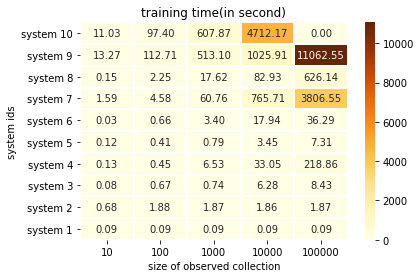

In [34]:
""" Time complexity for training self attention model """

system_ids = ['system 1', 'system 2', 'system 3', 'system 4', 'system 5', 'system 6', 'system 7', 'system 8', 'system 9', 'system 10']
system_ids = system_ids[::-1]
log_sizes = [10, 100, 1000, 10000, 100000]
# Every time we test the model with a system, we record the time
# These time values are copied from my personal notes
SA_times = np.array([[11.03, 97.40, 607.87, 4712.17, 0],
                    [13.27, 112.71, 513.10, 1025.91, 11062.55],
                    [0.15, 2.25, 17.62, 82.93, 626.14],
                    [1.59, 4.58, 60.76, 765.71, 3806.55],
                    [0.03, 0.66, 3.40, 17.94, 36.29],
                    [0.12, 0.41, 0.79, 3.45, 7.31],
                    [0.13, 0.45, 6.53, 33.05, 218.86],
                    [0.08, 0.67, 0.74, 6.28, 8.43],
                    [0.68, 1.88, 1.87, 1.86, 1.87],
                    [0.09, 0.09, 0.09, 0.09, 0.09]])
sns.heatmap(SA_times, cmap="YlOrBr", annot=True, vmin=0, fmt='.2f', linewidth=1, xticklabels=log_sizes, yticklabels=system_ids)
plt.xlabel("size of observed collection")
plt.ylabel("system ids")
plt.title("training time(in second)")
plt.show()

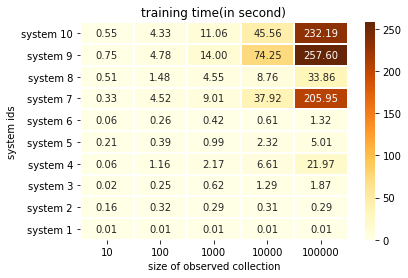

In [43]:
""" Time complexity for training self attention model """

LR_times = np.array([[0.55, 4.33, 11.06, 45.56, 232.19],
                     [0.75, 4.78, 14.00, 74.25, 257.60],
                     [0.51, 1.48, 4.55, 8.76, 33.86],
                     [0.33, 4.52, 9.01, 37.92, 205.95],
                     [0.06, 0.26, 0.42, 0.61, 1.32],
                     [0.21, 0.39, 0.99, 2.32, 5.01],
                     [0.06, 1.16, 2.17, 6.61, 21.97],
                     [0.02, 0.25, 0.62, 1.29, 1.87],
                     [0.16, 0.32, 0.29, 0.31, 0.29],
                     [0.01, 0.01, 0.01, 0.01, 0.01]])

sns.heatmap(LR_times, cmap="YlOrBr", annot=True, vmin=0, fmt='.2f', linewidth=1, xticklabels=log_sizes, yticklabels=system_ids)
plt.xlabel("size of observed collection")
plt.ylabel("system ids")
plt.title("training time(in second)")
plt.show()

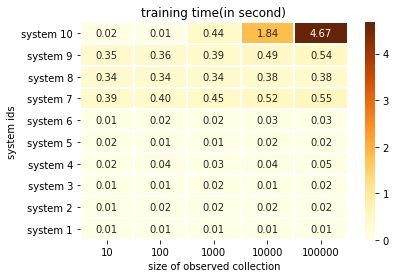

In [44]:
""" Time complexity for training neural network model """

NN_times = np.array([[0.02, 0.01, 0.44, 1.84, 4.67],
                     [0.35, 0.36, 0.39, 0.49, 0.54],
                     [0.34, 0.34, 0.34, 0.38, 0.38],
                     [0.39, 0.40, 0.45, 0.52, 0.55],
                     [0.01, 0.02, 0.02, 0.03, 0.03],
                     [0.02, 0.01, 0.01, 0.02, 0.02],
                     [0.02, 0.04, 0.03, 0.04, 0.05],
                     [0.01, 0.01, 0.02, 0.01, 0.02],
                     [0.01, 0.02, 0.02, 0.02, 0.02],
                     [0.01, 0.01, 0.01, 0.01, 0.01]])
sns.heatmap(NN_times, cmap="YlOrBr", annot=True, vmin=0, fmt='.2f', linewidth=1, xticklabels=log_sizes, yticklabels=system_ids)
plt.xlabel("size of observed collection")
plt.ylabel("system ids")
plt.title("training time(in second)")
plt.show()